In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from random import random
from random import seed

matplotlib.style.use('ggplot')
%matplotlib inline
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

In [3]:
# importing training data from localhost path
path = r"C:\Users\Arshnoor\Desktop\DSA SEM02\8004_Data_Mining\Project2\datatraining.txt"
df1 = pd.read_csv(path, sep = ",")
hidden = df1["Occupancy"].as_matrix()
obs = df1["CO2"].as_matrix()
obs1 = df1["Light"].as_matrix()

# importing test data from localhost path
path = r"C:\Users\Arshnoor\Desktop\DSA SEM02\8004_Data_Mining\Project2\datatest.txt"
df2 = pd.read_csv(path, sep = ",")
hidden_test = df1["Occupancy"].as_matrix()
obs_test = df1["CO2"].as_matrix()
obs_test1 = df1["Light"].as_matrix()

array([ 721.25      ,  714.        ,  713.5       , ...,  798.5       ,
        820.33333333,  821.        ])

Text(0,0.5,'Label')

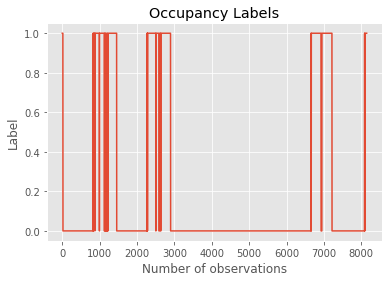

In [439]:
# plot Occupancy labels
plt.plot(hidden)
plt.title("Occupancy Labels")
plt.xlabel("Number of observations")
plt.ylabel("Label")

Text(0,0.5,'CO2 in ppm')

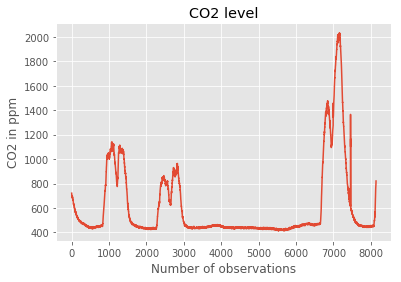

In [440]:
# plot attribute CO2 levels
plt.plot(obs)
plt.title("CO2 level")
plt.xlabel("Number of observations")
plt.ylabel("CO2 in ppm")

Mean of CO2 level:  606.5462431945632
Median of CO2 level:  453.5
Variance of CO2 level:  98797.61364328365


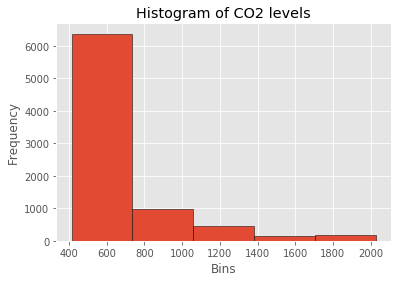

In [441]:
# mean, median and variance plus histogram plot of CO2 level
plt.hist(df1["CO2"], bins = 5, edgecolor = 'black')
print('Mean of CO2 level: ',df1["CO2"].mean(axis =0)) 
print('Median of CO2 level: ', df1["CO2"].median(axis =0))
print('Variance of CO2 level: ', df1["CO2"].var(axis =0)) 
plt.title('Histogram of CO2 levels')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()

Text(0.5,1,'Comparision of Light and Occupancy labels')

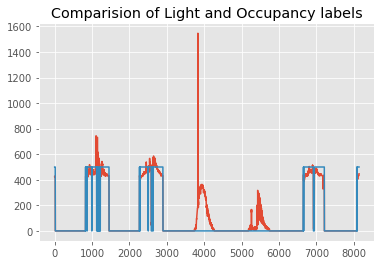

In [442]:
# comparision of light and occupancy labels
plt.plot(obs1)
plt.plot((hidden*500))
plt.title("Comparision of Light and Occupancy labels")

Text(0,0.5,'Light in Lux')

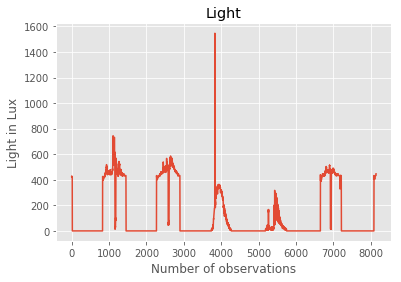

In [443]:
plt.plot(obs1)
plt.title("Light")
plt.xlabel("Number of observations")
plt.ylabel("Light in Lux")

Mean of Light:  119.51937451389756
Median of Light:  0.0
Variance of Light:  37929.8235027589


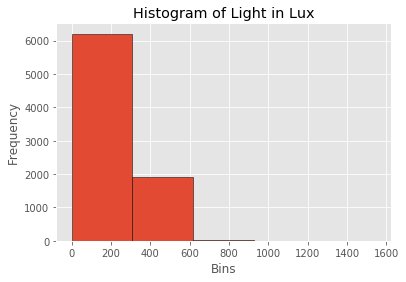

In [444]:
plt.hist(df1["Light"], bins = 5, edgecolor = 'black')
print('Mean of Light: ',df1["Light"].mean(axis =0)) 
print('Median of Light: ', df1["Light"].median(axis =0))
print('Variance of Light: ', df1["Light"].var(axis =0)) 
plt.title('Histogram of Light in Lux')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()

In [445]:
# discretize the continous variable into four clusters using KMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

# CO2 level, training dataset
data = obs
model = KMeans(n_clusters =3)
model = model.fit(data.reshape(-1,1))
dis_obs = model.labels_


# CO2 level, test dataset
data = obs_test
model_test = KMeans(n_clusters =3)
model_test = model_test.fit(data.reshape(-1,1))
dis_obs_test = model_test.labels_

# Light, training dataset
data = obs1
model = KMeans(n_clusters =3)
model = model.fit(data.reshape(-1,1))
dis_obs1 = model.labels_


# light, test dataset
data = obs_test1
model_test = KMeans(n_clusters =3)
model_test = model_test.fit(data.reshape(-1,1))
dis_obs_test1 = model_test.labels_

In [476]:
num_states = len(set(hidden))
num_obs = len(set(dis_obs))

# intialise pi matrix
pi = np.ones(num_states)
pi = pi/np.sum(pi, axis = 0, keepdims = True)

# intialise transition matrix
A = np.ones((num_states, num_states))
A = A/np.sum(A, axis =1, keepdims = True)

# intialise obervation matrix
O = np.ones((num_states, num_obs))
O = O/np.sum(O, axis = 1, keepdims = True)

In [477]:
def forward_recurse(pi, trans_m, obs_m, obs_seq,  num_obs, num_sates, alpha):
    pi = pi
    A = trans_m
    O = obs_m
    # alpha at time t = 1
    alpha[0, :] = pi * O[:,obs_seq[0]]
    # forward recurse
    for t in range(1, num_obs): 
        for s2 in range(num_states):
            for s1 in range(num_states):
                alpha_t = alpha[t-1, s1] * A[s1, s2] * O[s2, obs_seq[t]]
                alpha[t, s2] += alpha_t             
    return (alpha, np.sum(alpha[num_obs-1,:]))

In [478]:
def backward_recurse(pi, trans_m, obs_m, obs_seq, num_obs, num_sates,beta):
    pi = pi
    A = trans_m
    O = obs_m
    # beta at time t = T
    beta[num_obs-1, :] = 1
    # backward recurse
    for t in range(num_obs-2, -1, -1):
        for s1 in range(num_states):
            for s2 in range(num_states):
                beta_t = beta[t+1, s2] * A[s1, s2] * O[s2, obs_seq[t+1]]
                beta[t, s1] += beta_t
    
    return (beta, np.sum(pi * O[:, obs_seq[0]] * beta[0,:]))

In [479]:
def expectation(pi, A, O, sequence):
    num_obs = len(sequence)
    num_states = pi.shape[0]
    alpha = np.zeros((num_obs, num_states))
    beta = np.zeros((num_obs, num_states))
    # calculate alpha(t,i) for each sequence using Forward algorithm
    alpha, den_alpha = forward_recurse(pi, A, O, sequence, num_obs, num_states, alpha)
    # calculate beta(t,i) for each sequence using backward algorithm
    beta, den_beta = backward_recurse(pi, A, O, sequence, num_states, num_obs, beta)
    return alpha, beta, den_alpha, den_beta


def maximization(pi1, A1, O1,alpha, beta, den_alpha, den_beta, sequence, num_states):
    for i in range(0, len(sequence)):
        O1[:, sequence[i]] += alpha[i,:] * beta[i,:] /den_alpha
    for t in range(1, len(sequence)):
        for s1 in range(num_states):
            for s2 in range(num_states):
                theta = alpha[t-1,s1] * A[s1, s2] * O[s2, sequence[t]] * beta[t,s2] 
                A1[s1, s2] += theta/ den_alpha
    pi1 += alpha[0,:] * beta[0,:] / den_alpha
    return pi1, A1, O1


def baum_welch_algo(Obs_sequences, pi, A, O, iterations): 
    pi = np.copy(pi)
    A = np.copy(A)
    O  = np.copy(O)
    num_states = pi.shape[0]
    
    # number of iterations
    for each in range(iterations):
        pi1 = np.zeros_like(pi)
        A1 = np.zeros_like(A)
        O1 = np.zeros_like(O)
        
        for sequence in Obs_sequences:
            # expectation step
            alpha, beta, den_alpha, den_beta = expectation(pi, A, O, sequence)
            
            # Maximization step 
            pi1, A1, O1 = maximization(pi1, A1, O1,alpha, beta, den_alpha, den_beta, sequence, num_states)
            
            
        # normalizing pi matrix
        pi = pi1 / np.sum(pi1)
        # normalizing A matrix 
        for s in range(num_states):
            norm_da = np.sum(A1[s, :])
            A[s, :] = A1[s, :] / norm_da
        # normalizing O matrix  
        for s in range(num_states):
            norm_do = np.sum(O1[s, :])
            O[s, :] = O1[s, :] / norm_do

    return pi, A, O

In [503]:
def viterbi(pi, A, O , obs_seq):
    num_obs = len(obs_seq)
    num_states = pi.shape[0]
    alpha = np.zeros((num_obs, num_states))

    # initialization
    alpha[0, :] = pi * O[:,obs_seq[0]]
    backtracking = np.zeros((num_obs, num_states), dtype = 'int')
    # recursion
    for t in range(1, num_obs):
        for s2 in range(num_states):
            for s1 in range(num_states):
                score = alpha[t-1, s1] * A[s1, s2] * O[s2, obs_seq[t]]
                if score > alpha[t, s2]:
                    alpha[t, s2] = score
                    backtracking[t, s2] = s1
    
    # now follow backpointers to resolve the state sequence
    best_path = []
    max_state = np.argmax(alpha[num_obs -1,:])
    best_path.append(max_state)
    for i in range(num_obs-1, 0, -1):
        best_path.append(backtracking[i, best_path[-1]])
    best_seq = reversed(best_path)
     
    return list(best_seq)

In [504]:
import math 
training_seq = []
start_index = 0
index = 180
#iteration = math.floor(len(df1)/index)
iteration = 30
for i in range(iteration):
    training_seq.append(dis_obs[start_index:index])
    start_index = index
    index +=180

In [505]:
pi1, A1, O1 = baum_welch_algo(training_seq, pi, A, O, 1)

In [506]:
A2

array([[0.5, 0.5],
       [0.5, 0.5]])

In [507]:
pi2 = np.array([0.67, 0.33])
A2 = np.array([[0.71, 0.29],[0.68, 0.32]])
O2 = np.array([[0.81, 0.14, 0.05], [0.35, 0.16, 0.49]])

Prediction Accuracy of the model is : 0.6338779593197733


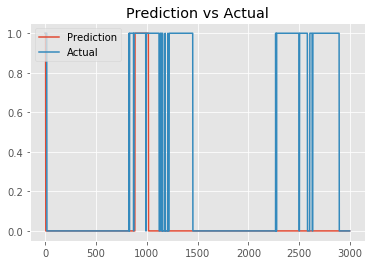

In [508]:
start_index = 1
end_index = 3000
b1 = viterbi(pi1, A1, O1, dis_obs_test[start_index:end_index])
a = np.mean(np.equal(b1, dis_obs_test[start_index:end_index]))
print("Prediction Accuracy of the model is :", a)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.plot(b1, label = 'Prediction')
ax1.plot(hidden_test[start_index:end_index], label = 'Actual')
plt.legend(loc = 2)
#plt.plot(b1, label = 'Prediction')
#plt.plot(hidden_test[start_index:end_index], label = 'Actual')
plt.title("Prediction vs Actual")
plt.show()

# LIGHT ATTRIBUTE

In [ ]:
import math 
training_seq = []
start_index = 0
index = 180
iteration = 30
for i in range(iteration):
    training_seq.append(dis_obs1[start_index:index])
    start_index = index
    index +=180

In [ ]:
pi2, A2, O2 = baum_welch_algo(training_seq, pi, A, O, 20)

In [ ]:
pi2 = np.array([0.50, 0.50])
A2 = np.array([[0.62, 0.38],[0.09, 0.91]])
O2 = np.array([[0.71, 0.00, 0.29], [0.20, 0.05, 0.75]])

In [ ]:
start_index = 1
end_index = 3000
b1  = viterbi(pi2, A2, O2, dis_obs_test[start_index:end_index])
a = np.mean(np.equal(b1, dis_obs_test1[start_index:end_index]))
print("Prediction Accuracy of the model is :", a)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.plot(b1, label = 'Prediction')
ax1.plot(hidden_test[start_index:end_index], label = 'Actual')
plt.legend(loc = 2)
#plt.plot(b1, label = 'Prediction')
#plt.plot(hidden_test[start_index:end_index], label = 'Actual')
plt.title("Prediction vs Actual")
plt.show()